In [2]:
import csv
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.stats as stats
#from sklearn.decomposition import PCA
import locale
import math
%matplotlib inline

In [3]:
DIR = '/Users/JMa/Learn/MLS/data'
df_player = pd.read_csv(DIR + '/raw/MLS_player.csv')
df_salary = pd.read_csv(DIR + '/raw/MLS_salaries.csv')
df_winners = pd.read_csv(DIR + '/raw/MLS_winners.csv')
df_player.head()


,Year,url,Player,Club,POS,GP,GS,MINS,G,A,SHOTS,SOG,GWG,PKG/A,HmG,RdG,G/90min,SC%
0,1996,http://www.mlssoccer.com/stats/season?&franchi...,Roy Lassiter,TB,F,30,30,2580,27,4,76,49,4,3/3,19,8,0.94,35.5
1,1996,http://www.mlssoccer.com/stats/season?&franchi...,Raul Diaz Arce,DC,F,28,28,2351,23,2,100,49,4,4/4,15,8,0.88,23.0
2,1996,http://www.mlssoccer.com/stats/season?&franchi...,Eduardo Hurtado,LA,F,26,26,2323,21,7,87,56,6,2/3,13,8,0.81,24.1
3,1996,http://www.mlssoccer.com/stats/season?&franchi...,Predrag Radosavljevic,KC,M,32,32,2880,18,13,140,61,3,7/8,14,4,0.56,12.9
4,1996,http://www.mlssoccer.com/stats/season?&franchi...,Brian McBride,CLB,F,28,28,2307,17,3,79,44,3,3/4,12,5,0.66,21.5


In [3]:
df_winners.head()
df_salary.head()

,Year,url,Player,Salary
0,2016,http://www.spotrac.com/mls/rankings/cap-hit/,Ricardo Kaká,"$7,167,500"
1,2016,http://www.spotrac.com/mls/rankings/cap-hit/,Sebastian Giovinco,"$7,115,556"
2,2016,http://www.spotrac.com/mls/rankings/cap-hit/,Michael Bradley,"$6,500,000"
3,2016,http://www.spotrac.com/mls/rankings/cap-hit/,Steven Gerrard,"$6,132,500"
4,2016,http://www.spotrac.com/mls/rankings/cap-hit/,Frank Lampard,"$6,000,000"


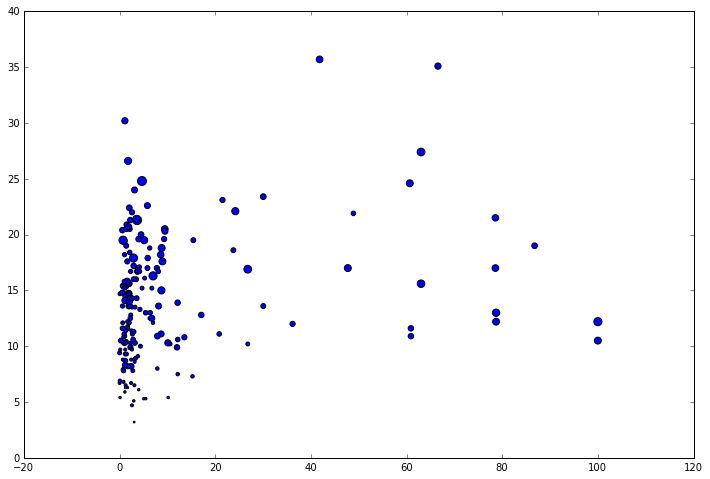

In [4]:
#df_salary = df_salary.drop('url',1)
df = pd.merge(df_player, df_salary, on = ['Year', 'Player'])

#No players who didn't play any minutes, only Forwards
df = df[df.MINS != 0]
df = df[df.POS == 'F']
df = df[df.SHOTS > np.mean(df.SHOTS)]
#Fix the salary to float
df['Salary']=(df['Salary'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

maxsal = max(df.Salary)
minsal = min(df.Salary)



df2 = pd.DataFrame(df.Salary)
df2['logSal'] = np.log(df.Salary)
df2['normSal'] = ((df.Salary - minsal) / (maxsal - minsal)*100)
df2['Player'] = df['Player']

df2['SC'] = df['SC%']
df2['G'] = df['G']
df2['Gmin'] = df['G/90min']
df2['SOG'] = df['SOG']
df2['Year'] = df['Year']

df2.to_csv(DIR + '/processed/Salarytogoals.csv')

fig, ax = plt.subplots(figsize=(12,8))  
ax.scatter(df2['normSal'], df2['SC'], s=df2['G']*3 ) 
plt.show()

In [9]:
team_avg_per_year = df_player.groupby(['Year', 'Club', 'Player']).agg('mean')
#team_avg_per_year['G/A'] = team_avg_per_year['A']/team_avg_per_year['G']team_avg_per_year
#team_avg_per_year.unstack().plot(kind='bar', stacked=True)
min(df.Salary) #32,600
max(df.Salary) #7,115,556
min(df['SC%'])
max(df['SC%'])
np.mean(df.SHOTS) #61.5
#np.mean(df2.normSal) #10.5
#np.mean(df['SC%']) #14.14


61.551912568306008

In [8]:
#df_player = df_player.drop('MINS', 1)
#df_player = df_player.drop('GP', 1)
#df_player = df_player.drop('MINS', 1)
COL = df_player[df_player['Club']== 'COL'].groupby('Year').mean()
COL['AtoG'] = COL['A']/COL['G']
COL.to_csv(DIR + '/processed/COL.csv')

In [11]:
test = df_player.drop('Club',1)
test = test.drop('Year',1)
test = test.drop('url',1)
test = test.drop('Player',1)
test = test.drop('POS',1)
test = test.drop('PKG/A',1)
data2 = (test - test.mean()) / test.std()

z, pval = stats.mstats.normaltest(data2)
assert pval.any() > 0.055

In [84]:
def gradientDescent(X, y, theta, alpha, iters):  
    temp = np.matrix(np.zeros(theta.shape))
    parameters = int(theta.ravel().shape[1])
    cost = np.zeros(iters)

    for i in range(iters):
        error = (X * theta.T) - y

        for j in range(parameters):
            term = np.multiply(error, X[:,j])
            temp[0,j] = theta[0,j] - ((alpha / len(X)) * np.sum(term))

        theta = temp
        cost[i] = computeCost(X, y, theta)

    return theta, cost

def computeCost(X, y, theta):  
    inner = np.power(((X * theta.T) - y), 2)
    return np.sum(inner) / (2 * len(X))

#data2.insert(0, 'ones', 1)
data2.head()
cols = data2.shape[1]  

X2 = data2.iloc[:,0:cols-1]  
#scoring chance
y2 = data2.iloc[:,cols-1:cols]

#convert to matrices and initialize theta
X2 = np.matrix(X2.values)  
y2 = np.matrix(y2.values)  
theta2 = np.matrix(np.array([np.zeros((X2.shape[1],1))]))  

alpha = 0.01
iters = 1000


# perform linear regression on the data set
g2, cost2 = gradientDescent(X2, y2, theta2, alpha, iters)

# get the cost (error) of the model
computeCost(X2, y2, g2)

0.32036382588725676

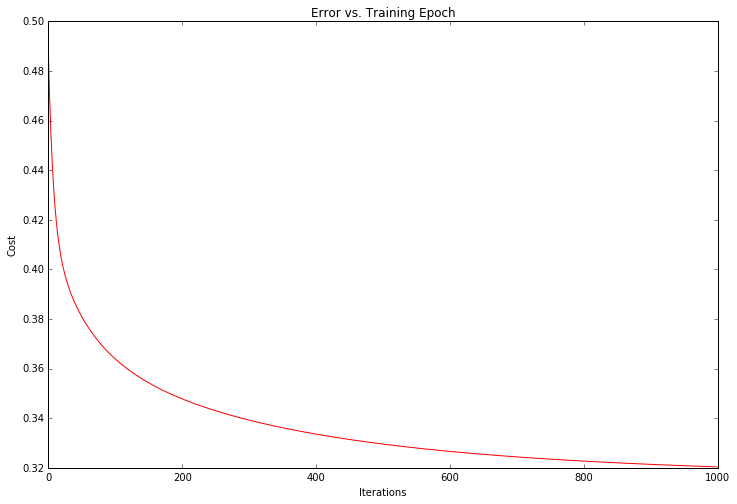

In [85]:
fig, ax = plt.subplots(figsize=(12,8))  
ax.plot(np.arange(iters), cost2, 'r')  
ax.set_xlabel('Iterations')  
ax.set_ylabel('Cost')  
ax.set_title('Error vs. Training Epoch') 

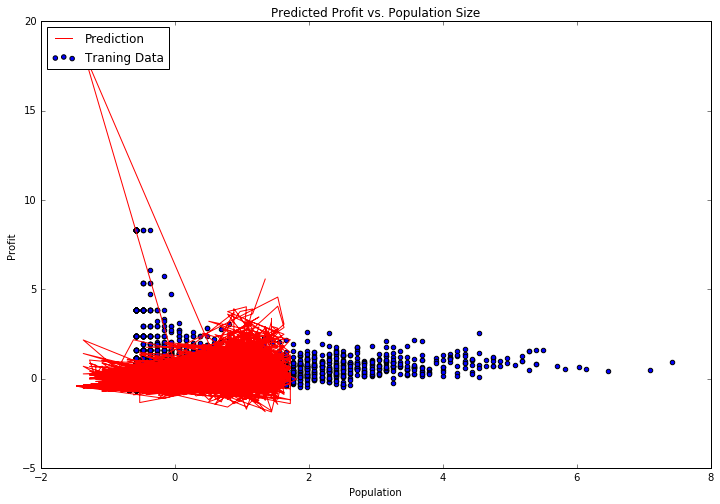

In [95]:
from sklearn import linear_model  
model = linear_model.LinearRegression()  
model.fit(X2, y2)  

x = np.array(X2[:, 1].A1)  
f = model.predict(X2).flatten()

fig, ax = plt.subplots(figsize=(12,8))  
ax.plot(x, f, 'r', label='Prediction')  
ax.scatter(data2.SOG, data2['SC%'], label='Training Data')  
ax.legend(loc=2)  
ax.set_xlabel('Population')  
ax.set_ylabel('Profit')  
ax.set_title('Predicted Profit vs. Population Size')  